In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap
import scvelo as scv
import scanpy as sc
import celldancer.utilities as cdutil
import numpy as np
import seaborn as sns

In [2]:
adata = scv.read("../velocyto/10X_multiome_mouse_brain.loom", cache = True)

In [3]:
adata.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata.obs_names]
adata.var_names_make_unique()

In [4]:
cell_annot = pd.read_csv('../cell_annotations.tsv', sep='\t', index_col=0)

In [5]:
adata = adata[cell_annot.index,:]
adata.obs['celltype'] = cell_annot['celltype']

In [6]:
adata = adata[adata.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]

In [7]:
adata.obs['celltype'] = cell_annot.loc[adata.obs_names, 'celltype']
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

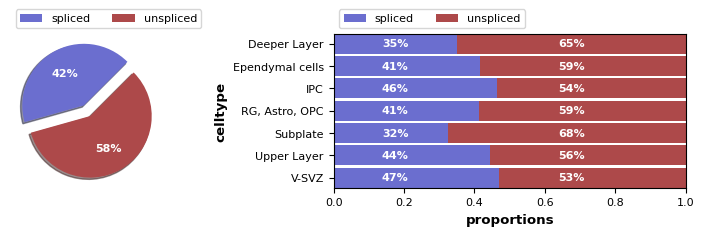

In [9]:
scv.pl.proportions(adata, groupby = "celltype")

In [10]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 23038 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
sc.tl.leiden(adata)

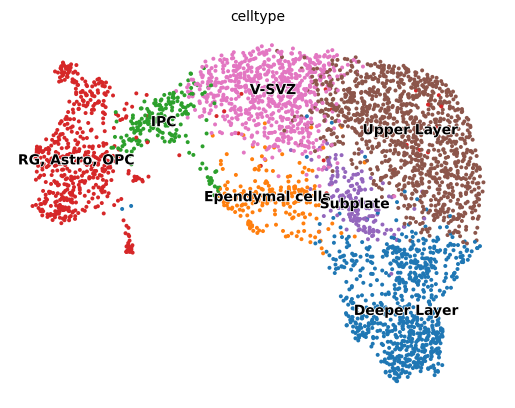

In [12]:
scv.tl.umap(adata)
scv.pl.umap(adata, color='celltype')

In [13]:
cdutil.adata_to_df_with_embed(adata,
                              us_para = ['Mu','Ms'],
                              cell_type_para = 'celltype',
                              embed_para = 'X_umap',
                              save_path = 'celldancer_predata.csv')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.91it/s]


,gene_name,unsplice,splice,cellID,clusters,embedding1,embedding2
0,Mybl1,0.027261,0.000000,AACCTTAAGTAGCGGG-1,"RG, Astro, OPC",12.208915,10.687434
1,Mybl1,0.000000,0.000000,AACAGCAAGTTATCCT-1,Subplate,9.751957,9.393094
2,Mybl1,0.000000,0.000000,AACTAGCTCAATGTGC-1,IPC,5.539106,8.916688
3,Mybl1,0.000000,0.000000,AAAGGCTCACCTGGTG-1,Ependymal cells,6.489529,8.962605
4,Mybl1,0.338705,0.058017,AACTAGCTCAGCACGC-1,"RG, Astro, OPC",1.354142,10.632039
...,...,...,...,...,...,...,...
3652995,Gm47283,0.122144,0.194629,TTTCTTGCAGCCTGCA-1,Ependymal cells,5.671690,8.905957
3652996,Gm47283,0.322022,0.338967,TTTGGTAAGCGATACT-1,V-SVZ,9.554563,13.046546
3652997,Gm47283,0.535050,0.396574,TTTGGTAAGTGAGCGG-1,"RG, Astro, OPC",1.055119,10.634164
3652998,Gm47283,0.352806,0.298848,TTTGCGGAGGGCCATC-1,Upper Layer,12.763318,7.944218


In [14]:
cell_type_u_s = pd.read_csv('celldancer_predata.csv')

In [15]:
loss_df, cellDancer_df = cd.velocity(cell_type_u_s, permutation_ratio = 0.125, n_jobs = 16)

Using /media/data/bmi111/KuanChiun/temp/MultiVelo/thesis/results/Mouse_E18/GEX/cellDancer_velocity_2024-05-20 23-02-05 as the output path.
Arranging genes for parallel job.
1000  genes were arranged to  63  portions.



Velocity Estimation: 100%|██████████| 63/63 [02:51<00:00,  2.24s/it]                                                                                                                                             
                                                                                                                                                                                                                 Not predicted gene list:['Rgs5', 'Ndufa4l2', 'AU021092', 'Epas1', 'Eng', 'Mecom', 'Kcnj8', 'Slc6a13', 'Apold1', 'Igf2', 'Fli1']. Try visualizing the unspliced and spliced columns of the gene(s) to check the quality.


In [3]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=200)

Caution! Overwriting the 'velocity' columns.


Pseudo random number generator seeds are set to:  [0, 1, 2, 3, 4, 5, 6, 7]


Generating Trajectories: 100%|███████████████████████████████████████████████████████████████████████████| 12936/12936 [00:01<00:00, 9077.16it/s]


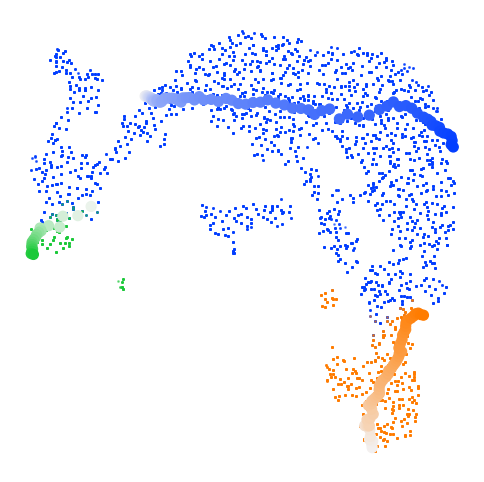

There are 3 clusters.
[0 1 2]
--- 138.70519852638245 seconds ---


In [5]:
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 8

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 3,
                               plot_long_trajs=True,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

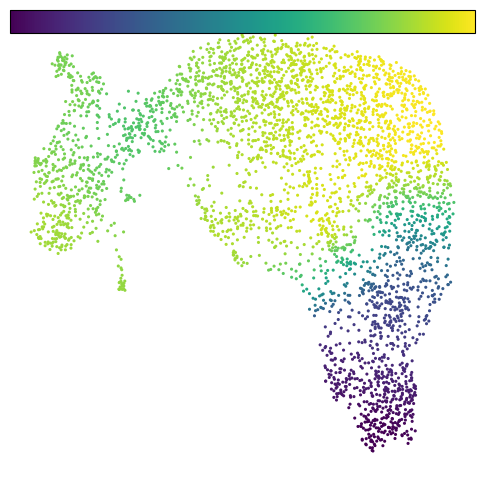

In [6]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=1.0, velocity=False)
ax.axis('off')
plt.show()

In [7]:
cellDancer_df.to_csv("data/celldancer_result.csv")

In [8]:
adata_celldancer = cdutil.to_dynamo(cellDancer_df)

In [9]:
adata_celldancer

AnnData object with n_obs × n_vars = 3653 × 989
    obs: 'clusters'
    var: 'highly_variable_genes', 'loss', 'use_for_dynamics', 'use_for_transition'
    uns: 'dynamics'
    obsm: 'X_cdr', 'velocity_cdr'
    layers: 'X_spliced', 'X_unspliced', 'M_s', 'M_u', 'velocity_S', 'velocity_U', 'alpha', 'beta', 'gamma'
    obsp: 'connectivities', 'distances'

In [10]:
clusters = list(cellDancer_df["cellID"][0:3653])

In [11]:
times = list(cellDancer_df["pseudotime"][0:3653])

In [12]:
match_dict = {k:v for k, v in zip(clusters, times)}

In [13]:
cellID = adata_celldancer.obs_names

In [14]:
pseudotime = [match_dict[item] for item in cellID]

In [15]:
adata_celldancer.obs["pseudotime"] = pseudotime

In [16]:
adata_celldancer.write_h5ad("data/celldancer.h5ad")